In [399]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

# Standard imports
import numpy as np
import pandas as pd
from collections import Counter, OrderedDict
import re
import string
import inspect
import os
import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score,precision_recall_curve




In [400]:
df = pd.read_csv('data/train.csv')
df.head()


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station
0,34d76816-cfc2-4bdd-b3a2-bf0c40b12689,Person search,2019-12-01T00:00:00+00:00,True,NaN,NaN,Male,18-24,Asian/Asian British - Any other Asian background,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall
1,83c87ec1-e6d4-4bbb-8e0c-159516706359,Person search,2019-12-01T00:09:00+00:00,True,NaN,NaN,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall
2,8c2eae4b-035a-492f-92d6-cd27e6c900a1,Person search,2019-12-01T00:10:00+00:00,True,NaN,NaN,Female,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall
3,e63a036a-a728-4efe-8e08-7198f56d6d0a,Person search,2019-12-01T00:10:00+00:00,False,NaN,NaN,Male,18-24,NaN,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall
4,40c70aca-1f7f-4efe-8c5b-ade0f2e9937d,Person search,2019-12-01T00:12:00+00:00,True,50.368247,-4.126646,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall


# 1. Flag Search Success

In [401]:
class Mask_OutcomePositive(BaseEstimator, TransformerMixin):

    #Return self nothing else to do here
    def fit( self, X=None, y = None):
        return self
    #Method that describes what we need this transformer to do
    def transform( self, X, y=None):

        df = X.copy()
        def mask(value):
            if value == 'A no further action disposal':
                return False
            elif value == 'Nothing found - no further action':
                return False
            else: 
                return True

        df['outcome_positive'] = df.Outcome.apply(mask)
        return df

In [402]:
df = Mask_OutcomePositive().fit_transform(df)
df

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,outcome_positive
0,34d76816-cfc2-4bdd-b3a2-bf0c40b12689,Person search,2019-12-01T00:00:00+00:00,True,NaN,NaN,Male,18-24,Asian/Asian British - Any other Asian background,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False
1,83c87ec1-e6d4-4bbb-8e0c-159516706359,Person search,2019-12-01T00:09:00+00:00,True,NaN,NaN,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False
2,8c2eae4b-035a-492f-92d6-cd27e6c900a1,Person search,2019-12-01T00:10:00+00:00,True,NaN,NaN,Female,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False
3,e63a036a-a728-4efe-8e08-7198f56d6d0a,Person search,2019-12-01T00:10:00+00:00,False,NaN,NaN,Male,18-24,NaN,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False
4,40c70aca-1f7f-4efe-8c5b-ade0f2e9937d,Person search,2019-12-01T00:12:00+00:00,True,50.368247,-4.126646,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660606,a23dc59d-29fe-48e5-b012-81feb6acfddf,Person search,2018-08-29T02:45:00+00:00,NaN,NaN,NaN,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,NaN,wiltshire,False
660607,425fde18-f7d5-4ebe-baf4-714cadd5a445,Person and Vehicle search,2018-08-29T21:00:00+00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Penalty Notice for Disorder,True,False,wiltshire,True
660608,7c249ab7-d4bf-47ef-86bd-aad51d7d2aab,Person search,2018-08-29T21:10:00+00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,wiltshire,False
660609,4fa54513-20c4-4a53-a5db-8a4bb85b1e32,Person search,2018-08-29T21:15:00+00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,wiltshire,False


In [403]:
columns = df.columns

In [404]:
class Mask_SearchSuccess(BaseEstimator, TransformerMixin):

    #Return self nothing else to do here
    def fit( self, X, y = None):
        return self
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None):

        df = X.copy()
        def mask(a, b):
            if a == True and b == True:
                return True
            else:
                return False  

        df['search_success'] = df.apply(lambda row: mask(row['outcome_positive'], row['Outcome linked to object of search']), axis=1)
        return df

In [405]:
df = Mask_SearchSuccess().fit_transform(df)
df

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,outcome_positive,search_success
0,34d76816-cfc2-4bdd-b3a2-bf0c40b12689,Person search,2019-12-01T00:00:00+00:00,True,NaN,NaN,Male,18-24,Asian/Asian British - Any other Asian background,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False,False
1,83c87ec1-e6d4-4bbb-8e0c-159516706359,Person search,2019-12-01T00:09:00+00:00,True,NaN,NaN,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False,False
2,8c2eae4b-035a-492f-92d6-cd27e6c900a1,Person search,2019-12-01T00:10:00+00:00,True,NaN,NaN,Female,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False,False
3,e63a036a-a728-4efe-8e08-7198f56d6d0a,Person search,2019-12-01T00:10:00+00:00,False,NaN,NaN,Male,18-24,NaN,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False,False
4,40c70aca-1f7f-4efe-8c5b-ade0f2e9937d,Person search,2019-12-01T00:12:00+00:00,True,50.368247,-4.126646,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660606,a23dc59d-29fe-48e5-b012-81feb6acfddf,Person search,2018-08-29T02:45:00+00:00,NaN,NaN,NaN,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,NaN,wiltshire,False,False
660607,425fde18-f7d5-4ebe-baf4-714cadd5a445,Person and Vehicle search,2018-08-29T21:00:00+00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Penalty Notice for Disorder,True,False,wiltshire,True,True
660608,7c249ab7-d4bf-47ef-86bd-aad51d7d2aab,Person search,2018-08-29T21:10:00+00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,wiltshire,False,False
660609,4fa54513-20c4-4a53-a5db-8a4bb85b1e32,Person search,2018-08-29T21:15:00+00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,wiltshire,False,False


# 2. Filter

In [406]:
# Filter rows of the station Metropolitain

In [407]:
class Filter_ColumnValue(BaseEstimator, TransformerMixin):
    """

    """
    def __init__(self, col, value):
        self.col = col
        self.value = value

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X = X[X['station'] != self.value]
        
        return X

In [408]:
df = Filter_ColumnValue(col='station', value='metropolitan').fit_transform(df)

In [409]:
class FilterRowsYear(BaseEstimator, TransformerMixin):
    """

    """
    def __init__(self, date_feature, year):
        self.date_feature = date_feature
        self.year = year

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X[self.date_feature] = pd.to_datetime(X[self.date_feature], errors='coerce', yearfirst=True, format="%Y-%m-%dT%H:%M:%S+%f:00")
        X = X[ X[self.date_feature].dt.year == self.year]

        return X

In [410]:
df = FilterRowsYear(date_feature='Date', year=2019).fit_transform(df)

In [411]:
# Filter rows based on Threshold to be used to filter police stations with less tha 30 observations

In [412]:
class FilterRowsThreshold(BaseEstimator, TransformerMixin):
    """

    """
    def __init__(self, col, threshold):
        self.col = col
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        filtered_list = X_copy.groupby(self.col)['observation_id'].count() < len(df)*self.threshold
        filtered_list = list(filtered_list[filtered_list.values == True].keys())
        X = X[X[self.col].isin(filtered_list)]
        return X

In [413]:
# df = FilterRowsThreshold(col='station', threshold=300).fit_transform(df)
# df

# 3. Missing Values Imputation

## Outcome linked to object of search and Removal of more than just outer clothing

In [414]:
df.isna().sum()

observation_id                                  0
Type                                            0
Date                                            0
Part of a policing operation                87360
Latitude                                    50103
Longitude                                   50103
Gender                                          0
Age range                                       0
Self-defined ethnicity                       3553
Officer-defined ethnicity                       0
Legislation                                 17091
Object of search                                0
Outcome                                         0
Outcome linked to object of search          70471
Removal of more than just outer clothing    37190
station                                         0
outcome_positive                                0
search_success                                  0
dtype: int64

In [415]:
class FixNA_OutcomeLinkedSearch_RemovalClothing(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X_, y=None):
        X = X_.copy()

        #stations without location known - btp   
        X['Outcome linked to object of search'] = X['Outcome linked to object of search'].fillna(False)
        X['Removal of more than just outer clothing'] = X['Removal of more than just outer clothing'].fillna(False)


        return X

In [416]:
df = FixNA_OutcomeLinkedSearch_RemovalClothing().fit_transform(df)
df.isna().sum()

observation_id                                  0
Type                                            0
Date                                            0
Part of a policing operation                87360
Latitude                                    50103
Longitude                                   50103
Gender                                          0
Age range                                       0
Self-defined ethnicity                       3553
Officer-defined ethnicity                       0
Legislation                                 17091
Object of search                                0
Outcome                                         0
Outcome linked to object of search              0
Removal of more than just outer clothing        0
station                                         0
outcome_positive                                0
search_success                                  0
dtype: int64

In [417]:
df = FixNA_OutcomeLinkedSearch_RemovalClothing().fit_transform(df)
df.isna().sum()

observation_id                                  0
Type                                            0
Date                                            0
Part of a policing operation                87360
Latitude                                    50103
Longitude                                   50103
Gender                                          0
Age range                                       0
Self-defined ethnicity                       3553
Officer-defined ethnicity                       0
Legislation                                 17091
Object of search                                0
Outcome                                         0
Outcome linked to object of search              0
Removal of more than just outer clothing        0
station                                         0
outcome_positive                                0
search_success                                  0
dtype: int64

In [418]:
## Coordinates

In [419]:
class FixNA_Coordinates(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X_, y=None):
        return self

    def transform(self, X_, y=None):
        X = X_.copy()
        columns = X.columns

        feature_name = 'station'
        stations_location = pd.read_csv('data/stations_location_2019.csv', sep=',')
        stations_location = stations_location[['PFA19NM', 'LONG', 'LAT','Shape__Area']]
        stations_location = stations_location.rename(columns={'PFA19NM':'station'})
        stations_location[feature_name] = stations_location[feature_name] \
                                                .str.lower() \
                                                .str.replace('police','') \
                                                .str.replace('&','and') \
                                                .str.replace('london, city of','city of london') \
                                                .str.strip() \
                                                .str.replace(' ','-')

        X = X.merge(stations_location,how='left', left_on='station', right_on='station')

        #stations known   
        X["Latitude"] = X["Latitude"].fillna(X["LAT"])
        X["Longitude"] = X["Longitude"].fillna(X["LONG"])

        #stations without location known - btp   
        X["Latitude"] = X["Latitude"].fillna(X["Latitude"].median())
        X["Longitude"] = X["Longitude"].fillna(X["LONG"].median())


        return X[columns]

In [420]:
df = FixNA_Coordinates().fit_transform(df)

In [421]:
## Self-defined ethnicity create besed on Self-defined ethnicity

In [422]:
class FixNA_Selfdefinedethnicity(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X_, y=None):
        data = X_.copy()
        data_ethnicity  = data.groupby(["Officer-defined ethnicity","Self-defined ethnicity"])['observation_id'].count().sort_values().reset_index()
        self.mapping = data_ethnicity.set_index(["Officer-defined ethnicity"])["Self-defined ethnicity"].to_dict()

        return self
    def transform(self, X_, y=None):
        X = X_.copy()
        X["Self-defined ethnicity"] = X.apply(lambda row: self.mapping[row["Officer-defined ethnicity"]]
                                if (pd.isnull(row["Self-defined ethnicity"]) and row["Officer-defined ethnicity"] in self.mapping.keys())
                                else row["Self-defined ethnicity"], axis=1)
        return X

In [423]:
df = FixNA_Selfdefinedethnicity().fit_transform(df)

# 4. Feature Engineering

In [424]:
class DateTransformer(BaseEstimator, TransformerMixin):
    """
    ok
    """
    def __init__(self, date_feature='Date'):
        self.date_feature = date_feature
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):

        df =  X.copy()
        def clean_df_time(df_):
            # fill null values with average from other wind towers
            df = df_.copy()
            df['Date'] = pd.to_datetime(df[self.date_feature], errors='coerce',yearfirst=True, format="%Y-%m-%dT%H:%M:%S+%f:00")# ,  infer_datetime_format=True, ,format="%Y-%m-%dT%H:%M:%S-%f"
            

            return df 
        

        df = clean_df_time(df)


        df['Day'] = df['Date'].dt.date
        df['Hour'] = df['Date'].dt.hour
        df['Minute'] = df['Date'].dt.minute


        df['Time (sin)'] = np.sin((2. * (df['Hour']+ df['Minute']/60) *  np.pi / 24)) 
        df['Time (cos)'] = np.sin((2. * (df['Hour']+ df['Minute']/60) *  np.pi / 24)) 

        return df

In [425]:
df = DateTransformer(date_feature='Date').fit_transform(df)

In [426]:
# 5. Select Features

In [427]:
df = pd.read_csv('data/train.csv')
df.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station
0,34d76816-cfc2-4bdd-b3a2-bf0c40b12689,Person search,2019-12-01T00:00:00+00:00,True,NaN,NaN,Male,18-24,Asian/Asian British - Any other Asian background,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall
1,83c87ec1-e6d4-4bbb-8e0c-159516706359,Person search,2019-12-01T00:09:00+00:00,True,NaN,NaN,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall
2,8c2eae4b-035a-492f-92d6-cd27e6c900a1,Person search,2019-12-01T00:10:00+00:00,True,NaN,NaN,Female,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall
3,e63a036a-a728-4efe-8e08-7198f56d6d0a,Person search,2019-12-01T00:10:00+00:00,False,NaN,NaN,Male,18-24,NaN,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall
4,40c70aca-1f7f-4efe-8c5b-ade0f2e9937d,Person search,2019-12-01T00:12:00+00:00,True,50.368247,-4.126646,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall


In [428]:
# Create the model

In [429]:
target = 'search_success'
df_sorted = df.sort_values(by="Date")

# Split data
df_train, df_test = train_test_split(df_sorted, test_size=0.25, shuffle=False)


In [430]:
# Group feaatures 
categorical_features = ['Type','Gender','Age range','Officer-defined ethnicity','Object of search','Removal of more than just outer clothing','station']
numeric_features = ['Time (sin)','Time (cos)']

# features = ['age', 'workclass', 'fnlwgt', 'education-num', 'education',
#         'marital-status', 'occupation', 'relationship', 'race', 'sex',
#         'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']

In [431]:
df.isna().sum()

observation_id                                   0
Type                                             0
Date                                             0
Part of a policing operation                153564
Latitude                                    112316
Longitude                                   112316
Gender                                           0
Age range                                        0
Self-defined ethnicity                        5574
Officer-defined ethnicity                        0
Legislation                                  27940
Object of search                                 0
Outcome                                          0
Outcome linked to object of search          473100
Removal of more than just outer clothing    426549
station                                          0
dtype: int64

In [432]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

standard_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [433]:
initial_pipe = Pipeline(
    steps=[
            ('OutcomePositive', Mask_OutcomePositive()),
            ('SearchSuccess', Mask_SearchSuccess()),
            ('Filter Metropolitain', Filter_ColumnValue(col='station', value='metropolitan')),
            # ('Filter Year 2019', FilterRowsYear(date_feature='Date', year=2019)),
            ('FixNA_OutcomeLinkedSearch_RemovalClothing', FixNA_OutcomeLinkedSearch_RemovalClothing()), 
            ('FixNA_Coordinates', FixNA_Coordinates()),
            ('FixNA_Selfdefinedethnicity', FixNA_Selfdefinedethnicity()),
            ('DateTransformer', DateTransformer())
            ])

In [434]:
pipeline = Pipeline([
        ('Initial Preprocessing Pipeline',initial_pipe),
        ('preprocessor', standard_preprocessor),
        ('model', LGBMClassifier(n_jobs=-1, random_state=42))
]    
)

In [435]:
df_train = initial_pipe.fit_transform(df_train)
df_test = initial_pipe.fit_transform(df_test)

In [436]:
len(df_train)

231123

# Pipeline for choosing the model (test and traning datasets will need different pipelines since creating the target features is not needed in test)

In [437]:
fase2_pipeline = Pipeline([
        ('preprocessor', standard_preprocessor),
        ('model', LGBMClassifier(n_jobs=-1, random_state=42))
]    
)

# Baseline model

In [438]:
X_train, y_train= df_train.drop(columns=[target]), df_train[target] 
X_test, y_test= df_test.drop(columns=[target]), df_test[target]

In [439]:
fase2_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Time (sin)', 'Time (cos)']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Type', 'Gender',
                                                 

precision 0.4846153846153846
recall 0.00430327868852459
f1 0.008530805687203793
roc_auc 0.501624528540851


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

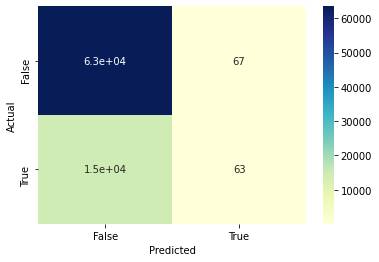

In [440]:
y_pred = fase2_pipeline.predict(X_test)
y_pred_proba = fase2_pipeline.predict_proba(X_test)[:, 1]


precision, recall, thresholds = precision_recall_curve( y_test, y_pred , pos_label=True)


precision = precision[:-1][1]
recall = recall[:-1][1]
f1_score_ = f1_score( y_test, y_pred, pos_label=True)
roc_auc_score_ = roc_auc_score(y_test, y_pred)
print("precision", precision)
print("recall", recall)
print('f1',f1_score_)
print('roc_auc',  roc_auc_score_)

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")



In [441]:
df_test.groupby('search_success')['observation_id'].count()

search_success
False    63554
True     14640
Name: observation_id, dtype: int64

In [442]:
def verify_retrieve_rates(X_test, y_true, y_test, sensitive_column, max_diff= 0.10):

    sensitive_column = sensitive_column
    max_diff = max_diff
    sensitive_classes = X_test[sensitive_column].unique()

    precisions={}
    for value in sensitive_classes:
        mask = X_test[sensitive_column] == value
        precisions[value]=recall_score(y_true[mask], y_test[mask], pos_label=True)
    rate_diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
    if rate_diff > max_diff:
        return False, rate_diff,  precisions
    else:
        return True, rate_diff

In [443]:
print('Officer-defined ethnicity', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Officer-defined ethnicity', max_diff = 0.10))
print('Age range', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Age range', max_diff = 0.10))
print('Gender', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Gender', max_diff = 0.10))
print('Stations', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='station', max_diff = 0.10))

X_test['combine'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Age range']+' ' + X_test['station']
X_test['combine'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Gender']
print('Combine', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='combine', max_diff = 0.10))

Officer-defined ethnicity (True, 0.005273623238523386)
Age range (True, 0.00723701214784182)
Gender (True, 0.004760105780128448)
Stations (False, 0.1506849315068493, {'thames-valley': 0.0, 'leicestershire': 0.010309278350515464, 'avon-and-somerset': 0.0, 'northumbria': 0.0, 'bedfordshire': 0.0, 'norfolk': 0.0, 'essex': 0.0, 'cumbria': 0.0, 'north-yorkshire': 0.0, 'lincolnshire': 0.0, 'hampshire': 0.0, 'north-wales': 0.0, 'merseyside': 0.0, 'west-mercia': 0.0, 'devon-and-cornwall': 0.0, 'btp': 0.0, 'staffordshire': 0.00963855421686747, 'humberside': 0.0, 'cleveland': 0.016260162601626018, 'south-yorkshire': 0.0, 'west-yorkshire': 0.0, 'durham': 0.05172413793103448, 'lancashire': 0.0, 'wiltshire': 0.0, 'kent': 0.0, 'cheshire': 0.0, 'suffolk': 0.0, 'hertfordshire': 0.00482315112540193, 'nottinghamshire': 0.0, 'surrey': 0.0, 'dorset': 0.0, 'dyfed-powys': 0.0, 'city-of-london': 0.1506849315068493, 'northamptonshire': 0.0, 'gloucestershire': 0.0, 'derbyshire': 0.0, 'warwickshire': 0.0, 'suss

In [444]:
df_test.columns

Index(['observation_id', 'Type', 'Date', 'Part of a policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
       'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'Outcome', 'Outcome linked to object of search',
       'Removal of more than just outer clothing', 'station',
       'outcome_positive', 'search_success', 'Day', 'Hour', 'Minute',
       'Time (sin)', 'Time (cos)'],
      dtype='object')

In [445]:
# Validation analysis 
df_test.predicted_outcome = y_pred

In [446]:
df_test_ = df_test[(df_test.search_success==True)&(df_test.predicted_outcome==True)]
print("True positives", df_test_.groupby(['Officer-defined ethnicity','Gender','search_success'])['observation_id'].count())

True positives Officer-defined ethnicity  Gender  search_success
Asian                      Male    True               2
White                      Male    True              61
Name: observation_id, dtype: int64


In [447]:

df_test_ = df_test[(df_test.search_success==False)&(df_test.predicted_outcome==True)]
print("False positives", df_test_.groupby(['Officer-defined ethnicity','Gender','search_success'])['observation_id'].count())

False positives Officer-defined ethnicity  Gender  search_success
Asian                      Male    False              1
White                      Male    False             66
Name: observation_id, dtype: int64


# First Iteration Model: Excluding half of the false from training data

In [448]:
print(df_train.search_success.value_counts())

df_train_true = df_train[df_train.search_success == True]

df_train_false = df_train[df_train.search_success == False]
df_train_false, df_train_false_exclude = train_test_split(df_train_false,  test_size=0.5, shuffle=True )

print('False',df_train_false.search_success.value_counts())
print('True',df_train_true.search_success.value_counts())


#Append True and False
df_train = df_train_true.append(df_train_false, ignore_index=True)
df_train.search_success.value_counts()

False    183477
True      47646
Name: search_success, dtype: int64
False False    91738
Name: search_success, dtype: int64
True True    47646
Name: search_success, dtype: int64


False    91738
True     47646
Name: search_success, dtype: int64

In [449]:
X_train, y_train= df_train.drop(columns=[target]), df_train[target] 
X_test, y_test= df_test.drop(columns=[target]), df_test[target]

In [450]:
fase2_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Time (sin)', 'Time (cos)']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Type', 'Gender',
                                                 

In [451]:
def plot_roc_curve(roc_auc, fpr, tpr):
    # Function to plot ROC Curve
    # Note: this is ALL just matplotlib stuff, nothing scientific about it! 
    
    # Inputs: 
    #     roc_auc - AU ROC value (float)
    #     fpr - false positive rate (output of roc_curve()) array
    #     tpr - true positive rate (output of roc_curve()) array
    
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(fpr, tpr, color='orange', lw=lw, label='ROC curve (AUROC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='random')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

precision 0.3521787093215665
recall 0.1744535519125683
f1 0.2333272428284305
roc_auc 0.5502660811141027


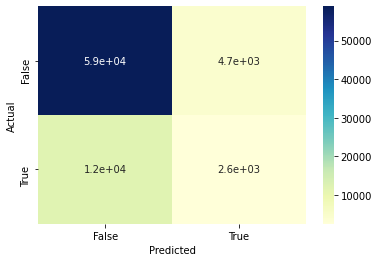

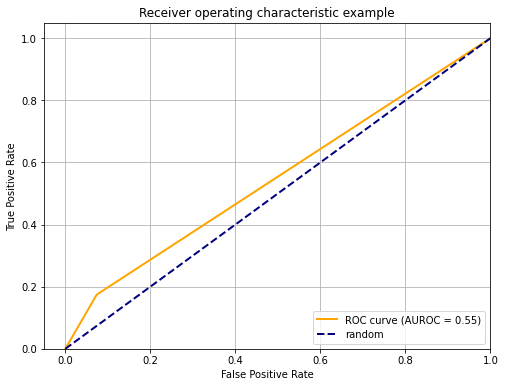

In [452]:
y_pred = fase2_pipeline.predict(X_test)
y_pred_proba = fase2_pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve( y_test, y_pred , pos_label=True)


precision = precision[:-1][1]
recall = recall[:-1][1]
f1_score_ = f1_score( y_test, y_pred, pos_label=True)
roc_auc_score_ = roc_auc_score(y_test, y_pred)
print("precision", precision)
print("recall", recall)
print('f1',f1_score_)
print('roc_auc',  roc_auc_score_)

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")


fpr, tpr, thresholds = roc_curve( y_test, y_pred , pos_label=True)
plot_roc_curve(roc_auc_score_, fpr, tpr)

In [453]:
print('Officer-defined ethnicity', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Officer-defined ethnicity', max_diff = 0.10))
print('Age range', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Age range', max_diff = 0.10))
print('Gender', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Gender', max_diff = 0.10))
print('Stations', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='station', max_diff = 0.10))

X_test['combine'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Age range']+' ' + X_test['station']
X_test['combine'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Gender']
print('Combine', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='combine', max_diff = 0.10))

Officer-defined ethnicity (True, 0.0828695833898882)
Age range (False, 0.3116387182467209, {'25-34': 0.14706642543292842, '18-24': 0.3116387182467209, '10-17': 0.01620491374803973, 'over 34': 0.027237354085603113, 'under 10': 0.0})
Gender (False, 0.1870797128825085, {'Male': 0.1870797128825085, 'Female': 0.05583392984967788, 'Other': 0.0})
Stations (False, 0.735632183908046, {'thames-valley': 0.0, 'leicestershire': 0.28865979381443296, 'avon-and-somerset': 0.30716723549488056, 'northumbria': 0.125, 'bedfordshire': 0.21875, 'norfolk': 0.0, 'essex': 0.3827433628318584, 'cumbria': 0.15625, 'north-yorkshire': 0.0, 'lincolnshire': 0.0, 'hampshire': 0.18509316770186335, 'north-wales': 0.01593625498007968, 'merseyside': 0.01650846058605035, 'west-mercia': 0.30131004366812225, 'devon-and-cornwall': 0.1416184971098266, 'btp': 0.4205607476635514, 'staffordshire': 0.2746987951807229, 'humberside': 0.0, 'cleveland': 0.34959349593495936, 'south-yorkshire': 0.011029411764705883, 'west-yorkshire': 0.

# Create the APP

In [454]:
lista = []
for i in categorical_features:
    print("'"+i+"'",":",list(df[i].unique()), ",")

'Type' : ['Person search', 'Person and Vehicle search', 'Vehicle search'] ,
'Gender' : ['Male', 'Female', 'Other'] ,
'Age range' : ['18-24', '25-34', 'over 34', '10-17', 'under 10'] ,
'Officer-defined ethnicity' : ['Asian', 'White', 'Black', 'Other', 'Mixed'] ,
'Object of search' : ['Controlled drugs', 'Offensive weapons', 'Stolen goods', 'Article for use in theft', 'Articles for use in criminal damage', 'Firearms', 'Anything to threaten or harm anyone', 'Crossbows', 'Evidence of offences under the Act', 'Fireworks', 'Psychoactive substances', 'Game or poaching equipment', 'Evidence of wildlife offences', 'Detailed object of search unavailable', 'Goods on which duty has not been paid etc.', 'Seals or hunting equipment'] ,
'Removal of more than just outer clothing' : [False, True, nan] ,
'station' : ['devon-and-cornwall', 'dyfed-powys', 'derbyshire', 'bedfordshire', 'avon-and-somerset', 'cheshire', 'sussex', 'north-yorkshire', 'cleveland', 'merseyside', 'north-wales', 'wiltshire', 'norf